# <div align="center">Lab 10 - Time series model comparison  </div>
## <div align="center"> Elder de Sousa Whalen </div>
## <div align="right"> 11.16.2020 </div>

### Overview

A time series is a series of data collected over a period of time. Time series analysis incorporate methods that extract meaningful information from a time series data, the most common being forecasting. In time series forecasting, models are created based on the available information (collected data) to predict values of the same information into the future.

In this lab, two different models are compared and evaluated based on their respective MSE values for the test data: ARIMA and FBprophet. Other more common measures used to compare time series models are the AIC and BIC.

AIC stands for [Akike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) "is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data." In other words, AIC is a method to compare the quality of different models.

BIC stands for Bayesian Information criterion, and is also a method for model selection. It's based on the likelihood function and has a close relation to the AIC. 

These statistics are calculated to compare performance of different ARIMA models. For both AIC and BIC, a lower score is desired.


### Data

The data used in this lab was obtained from the [National Snow & Ice Data Center]. More specically, the data contains the measures of the monthly average of sea ice area in millions of square km from 1978-11 to 2020-10.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\KiehMinn\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
url1 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_01_extent_v3.0.csv"
url2 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_02_extent_v3.0.csv"
url3 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_03_extent_v3.0.csv"
url4 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_04_extent_v3.0.csv"
url5 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_05_extent_v3.0.csv"
url6 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_06_extent_v3.0.csv"
url7 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_07_extent_v3.0.csv"
url8 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_08_extent_v3.0.csv"
url9 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_09_extent_v3.0.csv"
url10 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_10_extent_v3.0.csv"
url11 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_11_extent_v3.0.csv"
url12 = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_12_extent_v3.0.csv"

In [4]:
#Loading data into dataframe to be used,combine all 12 csv 
# files into one dataframe so we have proper dataset with all 12 months
df = pd.concat(map(pd.read_csv, [url1, url2, url3, url4, url5, url6,
                                url7, url8, url9, url10, url11, url12]))
#remove the spaces that appear in column headings
df.columns = df.columns.str.replace(' ', '') 
#dropping bad rows from dataset
df = df[df['area'] != -9999.00]
#dropping columns we don't need
df=df.drop(['data-type','region','extent'], axis=1)
#create a unique time column to sort on
df["time"] = df["year"].apply(str) + "-" + df["mo"].apply(str).str.zfill(2)
#drop the old columns we don't need now
df=df.drop(['year', 'mo'], axis=1)
#make sure our new unique column is the index which is important for time series data (needs to be in order!)
#sort it!
df = df.sort_values(by=['time'])
#make sure it's in order
df.head(20)

,area,time
0,9.04,1978-11
0,10.90,1978-12
0,12.41,1979-01
0,13.18,1979-02
0,13.21,1979-03
0,12.53,1979-04
0,11.11,1979-05
0,9.34,1979-06
0,6.69,1979-07
0,5.06,1979-08


In [5]:
#df['time'] = df['time'].to_numpy(dtype="datetime64[ns]")
df['time'] = pd.to_datetime(df['time'], format='%Y-%m')
y = df.set_index(['time'])

In [6]:
y.head()

,area
time,
1978-11-01,9.04
1978-12-01,10.90
1979-01-01,12.41
1979-02-01,13.18
1979-03-01,13.21


### Exploratory Data Analysis

In [7]:
print('There are %i observations' % y.size)

There are 501 observations


In [8]:
# Check for missing values
missing = y.isnull().values.any()
if ( missing == False):
    print('No missing values')
else:
    print('Oh uh. There are missing values!')

No missing values


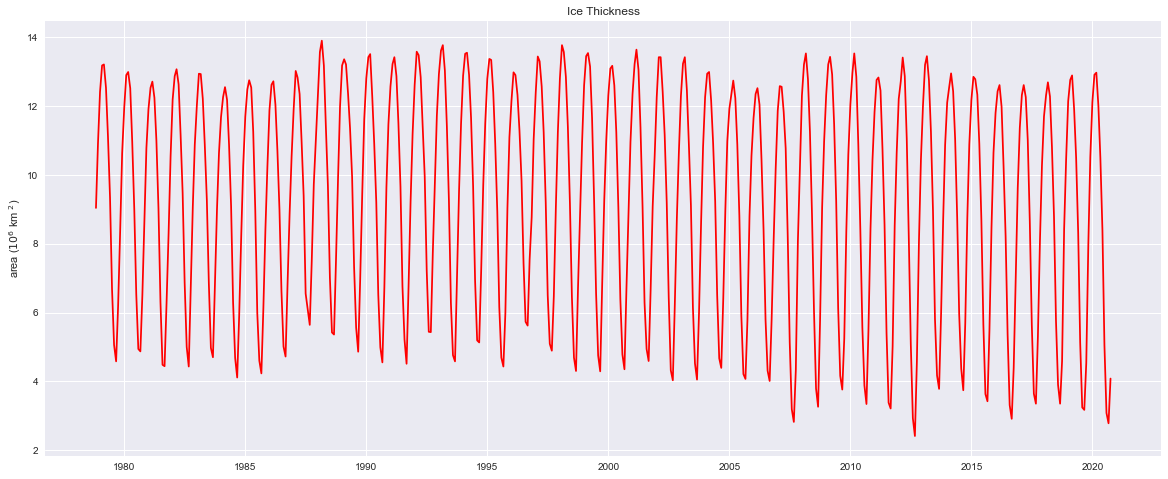

In [9]:
# Plot the time series
plt.style.use('seaborn')
plt.figure(figsize=(20,8))
plt.plot(y, 'r')
plt.title('Ice Thickness')
plt.ylabel('area ($10^6$ km $^2$)');

The plot above indicates the presence of a seasonal component in the data but it's difficult to visualize if there is any trend.

#### Check if stationary

The The Augmented Dickey-Fuller test (adfuller) is used to check if the series is stationary. It has the following null and alternative hypothesis:

* Null Hypothesis (H0): Suggests the time series is not stationary.
* Alternate Hypothesis (H1): Suggests the time series is stationary.

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.

In [9]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from statsmodels.tsa.stattools import adfuller
#X = df.area
result = adfuller(y.area)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.567067
p-value: 0.500112
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


From the results of the adfuller test above, we fail to reject the null hypothesis, indicating that the series is not stationary.

Repeating the same test but now after taking the first difference on the series, we get:

In [10]:
# the first difference and check again
X = y.area.diff().dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.524456
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


The results show that after taking the first difference on the series, it became stationary.

#### ACF and PACF

The auto-correlation function (ACF) gives values of auto-correlation of a series with its lagged values. It represents how the present values is related to its past values. It's used to identify the order (q) of the moving average (MA) process in models like the ARIMA.

The partial auto-correlation function (PACF) gives values of correlation of the residuals of a value with the next lag value in a series. It's used to identify the order (p) of the auto regressive (AR) process in models like the ARIMA.

To have an estimate of the order, p or q, in an ARIMA(p,d,q) model we count how many lags cross the shaded area in the ACF and PACF plots.

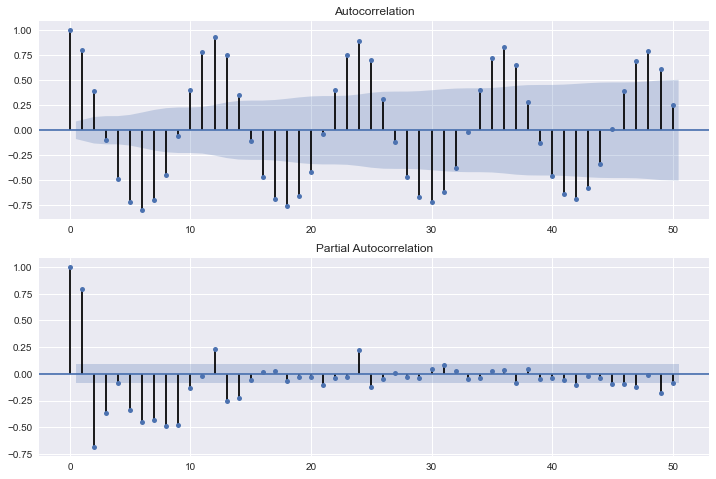

In [11]:
#plot the ACF and PACF plots

import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y.area.diff().dropna(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y.area.diff().dropna(), lags=50, ax=ax2)
plt.show()

The ACF plot shows the presence of seasonality. The PACF plot shows that many lags are crossing the shaded area, indicating that the AR process in an ARIMA model would have a high order (p) value. 

<Figure size 1440x1440 with 0 Axes>

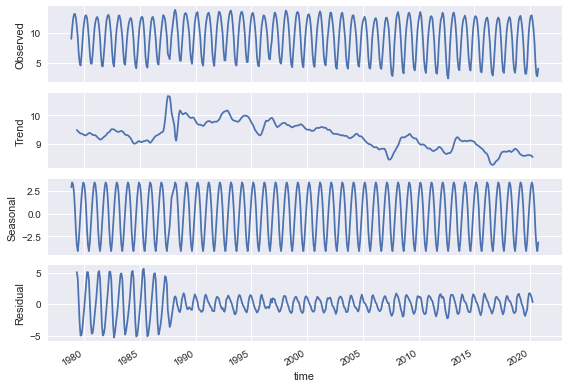

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(20,20))
decomp = seasonal_decompose(y, model='additive', freq=12)
dc_plt = decomp.plot()

Using the seasonal_decompose method we can show the decomposition of a time series into, trend, seasonal and residual components. The graph above was created from the original series and we can confirm the presence a seasonal component and we can also observe a trend, indicating that the thickness of the ice is decreasing over time.

The graph below also shows the same 3 componentes of the time series, trend, seasonal and residual but after taking the first difference in the original series. It shows that there is no longer a trend which is inline to what was reported by adfuller test.

Both in the original and in the difference series, the residuals shows that there was a much higher variability in the earlier years and it suddenly was reduced in the early 90s.

<Figure size 1440x1440 with 0 Axes>

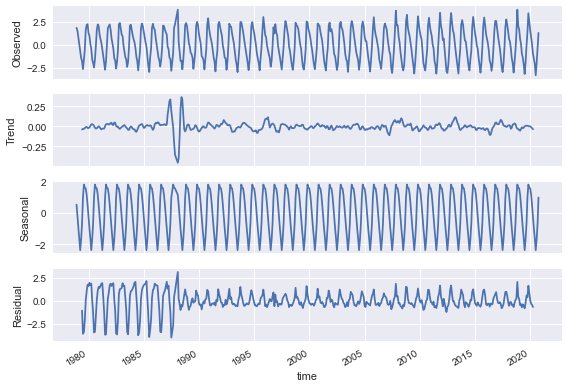

In [13]:
plt.figure(figsize=(20,20))
decomp = seasonal_decompose(y.diff().dropna(), model='additive', freq=12)
dc_plt = decomp.plot()

### Models

The models selected to compare are the ARIMA and FBprophet. Before performing the analysis, the data set is split between train and test data. The train data contain observations from the beginning to 2009-12. The test data contains observations from 2010-01 to the last observation, 2020-10.

In [22]:
traindata, testdata = df.iloc[:371,1], df.iloc[371:,1]
print(traindata.tail())
testdata.head()

30   2009-08-01
30   2009-09-01
30   2009-10-01
31   2009-11-01
31   2009-12-01
Name: time, dtype: datetime64[ns]


31   2010-01-01
31   2010-02-01
31   2010-03-01
31   2010-04-01
31   2010-05-01
Name: time, dtype: datetime64[ns]

In [23]:
train, test = y.iloc[:371,0], y.iloc[371:,0]

#### ARIMA

ARIMA stands for [autoregressive integrated moving average](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and is a time series model used to better understand a time series data and to make predictions of future observations.

It's applied in cases where the data shows evidence non-stationarity, where a difference can be applied multiple times in an attempt to remove the non-stationarity. The difference step corresponds to the integrated part of the model.

ARIMA models are usually represented with the notation ARIMA(p,d,q). The p is the order, or number of time lags, of the autoregressive part (AR). The d corresponds to the number of differences performed on the series. And the q is the order of the moving average (MA) part of the model.

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In an attempt to find the best parameters p, d, q that results in a model with the lowest MSE of the predictions and the test data a grid search is performed.

In [17]:
#https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
import warnings
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train, test = X.iloc[:371,0], X.iloc[371:,0]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [18]:
d_values=range(1,3)
p_values=[1,2,4,5,7,9]
q_values=range(0,5)
warnings.filterwarnings('ignore')
evaluate_models(y, p_values, d_values, q_values)

ARIMA(1, 1, 0) MSE=1.223
ARIMA(1, 1, 1) MSE=0.863
ARIMA(1, 2, 0) MSE=0.922
ARIMA(2, 1, 0) MSE=0.573
ARIMA(2, 1, 4) MSE=0.265
ARIMA(2, 2, 0) MSE=0.899
ARIMA(4, 1, 0) MSE=0.517
ARIMA(4, 2, 0) MSE=0.768
ARIMA(5, 1, 0) MSE=0.476
ARIMA(5, 1, 2) MSE=0.178
ARIMA(5, 1, 3) MSE=0.130
ARIMA(5, 2, 0) MSE=0.771
ARIMA(7, 1, 0) MSE=0.271
ARIMA(7, 1, 1) MSE=0.161
ARIMA(7, 1, 2) MSE=0.144
ARIMA(7, 1, 4) MSE=0.120
ARIMA(7, 2, 0) MSE=0.603
ARIMA(7, 2, 3) MSE=0.208
ARIMA(9, 1, 0) MSE=0.138
ARIMA(9, 1, 1) MSE=0.129
ARIMA(9, 1, 2) MSE=0.122
ARIMA(9, 1, 3) MSE=0.121
ARIMA(9, 1, 4) MSE=0.119
ARIMA(9, 2, 0) MSE=0.282
ARIMA(9, 2, 1) MSE=0.144
ARIMA(9, 2, 2) MSE=0.137
Best ARIMA(9, 1, 4) MSE=0.119


The grid search showed that the ARIMA(9,1,4) had the lowest MSE of all the models tested. ARIMA(9,1,4) also returned the lowest AIC and BIC values (shown by the summary below) when compared to other models that also had a low MSE value like ARIMA(7,1,4). It is possible that there might be other ARIMA models with different values for p, d, q that result in lower values of AIC and BIC. 

In [32]:
arima_model = ARIMA(y, order=(9,1,4))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.area   No. Observations:                  500
Model:                 ARIMA(9, 1, 4)   Log Likelihood                -228.984
Method:                       css-mle   S.D. of innovations              0.378
Date:                Mon, 16 Nov 2020   AIC                            487.968
Time:                        12:10:29   BIC                            551.187
Sample:                             1   HQIC                           512.775
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0023      0.003     -0.681      0.496      -0.009       0.004
ar.L1.D.area     0.4754      0.074      6.457      0.000       0.331       0.620
ar.L2.D.area    -0.1989      0.059     -3.378      0.001      -0.314      -0.083
ar.L3.D.area    -0.8895      0.062    -14.298      0.000      -1.011      -0.768
ar.L4.D.area     0.4057      0.083      4.892      0.000       0.243       0.568
ar.L5.D.area    -0.3794      0.061     -6.243      0.000      -0.499      -0.260
ar.L6.D.area    -0.4186      0.066     -6.342      0.000      -0.548      -0.289
ar.L7.D.area    -0.0560      0.048     -1.174      0.241      -0.150       0.038
ar.L8.D.area    -0.1866      0.047     -3.986      0.000      -0.278      -0.095
ar.L9.D.area    -0.4615      0.061     -7.579      0.000      -0.581      -0.342
ma.L1.D.area    -0.3482      0.080     -4.326      0.000      -0.506      -0.190
ma.L2.D.area    -0.0755      0.046     -1.626      0.105      -0.167       0.015
ma.L3.D.area     0.5013      0.069      7.284      0.000       0.366       0.636
ma.L4.D.area    -0.5503      0.049    -11.127      0.000      -0.647      -0.453
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8665           -0.5019j            1.0014           -0.0836
AR.2            0.8665           +0.5019j            1.0014            0.0836
AR.3            0.5042           -0.8800j            1.0142           -0.1672
AR.4            0.5042           +0.8800j            1.0142            0.1672
AR.5            0.0257           -1.1056j            1.1059           -0.2463
AR.6            0.0257           +1.1056j            1.1059            0.2463
AR.7           -1.0144           -0.0000j            1.0144           -0.5000
AR.8           -1.0913           -0.7085j            1.3011           -0.4084
AR.9           -1.0913           +0.7085j            1.3011            0.4084
MA.1           -1.0582           -0.0000j            1.0582           -0.5000
MA.2            0.3437           -1.1053j            1.1575           -0.2020
MA.3            0.3437           +1.1053j            1.1575            0.2020
MA.4            1.2818           -0.0000j            1.2818           -0.0000
-----------------------------------------------------------------------------
"""

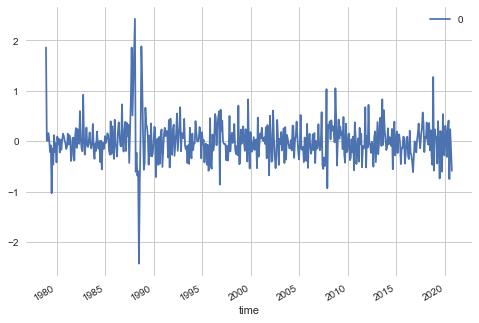

In [36]:
residuals = pd.DataFrame(arima_model_fit.resid)
residuals.plot()

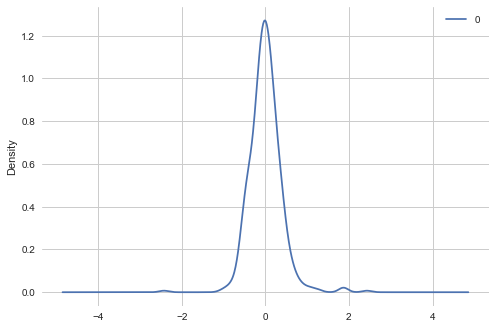

In [37]:
residuals.plot(kind='kde')

In [20]:
residuals.describe()

,0
count,500.000000
mean,0.000874
std,0.388331
min,-2.425847
25%,-0.206534
50%,-0.022638
75%,0.185259
max,2.428132


The plot of the residuals and the summary for the ARIMA(9,1,4) show that they are very close to a normal distribution.

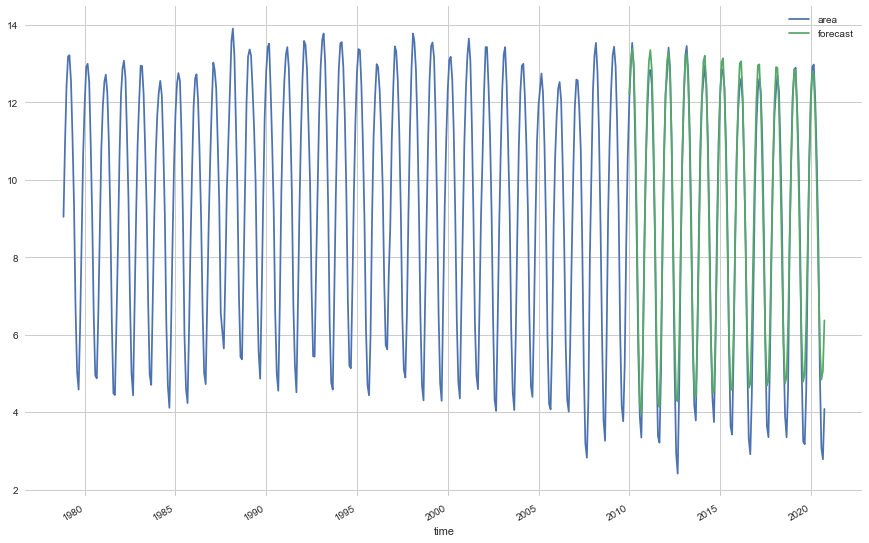

In [35]:
#https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
ax = y.loc['1978-11-01':].plot(ax=ax)
fig = arima_model_fit.plot_predict('2010-01-01', '2020-10-01', dynamic=True, alpha=0.05, ax=ax, plot_insample=False)

The plot above compares the test data with the predicted values obtained from the ARIMA(9,1,4). The green line(forecast) represents the predicted values. It follows the original data very closely, except towards the end, at the bottom. It seems the predicted values are showing less variance as the time progress, something that was observed in the plot of the residuals using the seasonal_decompose function, but in a different period in time.

In [44]:
arima_pred = arima_model_fit.predict(start=test.index[0], end=test.index[-1], typ='levels', dynamic=True)

#### FBprophet

Developed by Facebook to provide automatic forecasting of univariate(one variable) time series data. It has an open-source library and was designed to automatically find a good set of hyperparameters for a model to make forecasts for data with trends and seasonal structure

In [10]:
from fbprophet import Prophet

In [11]:
column_titles = ['time', 'area'] 
df_pro = df.reindex(columns=column_titles)
df_pro.rename(columns={'time': 'ds', 'area': 'y'}, inplace=True)
df_pro.head()

,ds,y
0,1978-11-01,9.04
0,1978-12-01,10.90
0,1979-01-01,12.41
0,1979-02-01,13.18
0,1979-03-01,13.21


In [24]:
train_pro, test_pro = df_pro.iloc[:371], df_pro.iloc[371:]

In [25]:
model_prophet = Prophet()
model_prophet.fit(train_pro)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

df_cv = cross_validation(model_prophet, horizon=365)
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 358 forecasts with cutoffs between 1979-11-30 23:59:59.999999635 and 2009-11-30 23:59:59.999999635
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints gre

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 00:00:00.000000365,7.740467,2.782169,0.585913,0.076381,0.0227,0.589385


Creating a dataframe with prediction data:

In [26]:
#https://towardsdatascience.com/a-quick-run-through-of-holt-winters-sarima-and-fb-prophet-c6370c6f32f1
future = model_prophet.make_future_dataframe(periods=501-371, freq='M')
forecast = model_prophet.predict(future)

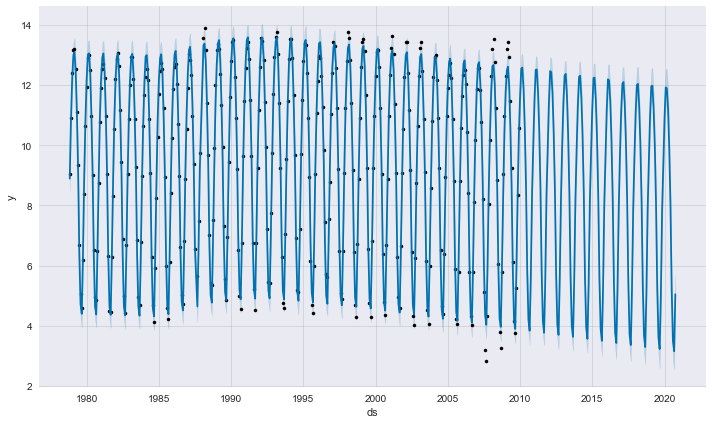

In [27]:
#https://towardsdatascience.com/a-quick-run-through-of-holt-winters-sarima-and-fb-prophet-c6370c6f32f1
proph_plt = model_prophet.plot(forecast)

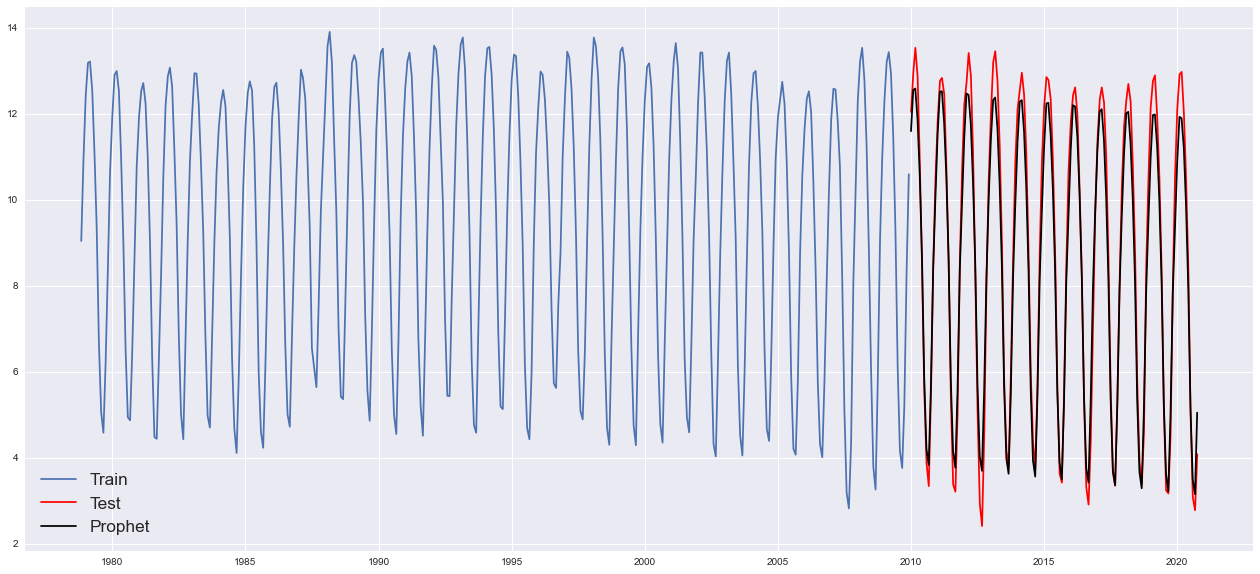

In [28]:
#https://towardsdatascience.com/a-quick-run-through-of-holt-winters-sarima-and-fb-prophet-c6370c6f32f1
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(forecast['ds'][371:], forecast['yhat'][371:], label='Prophet', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.show()

FBprohpet model seems better than the ARIMA(9,1,4) when comparing the lower values in the series (between 3-6). It seems to miss more on the higher values.

### Conclusions

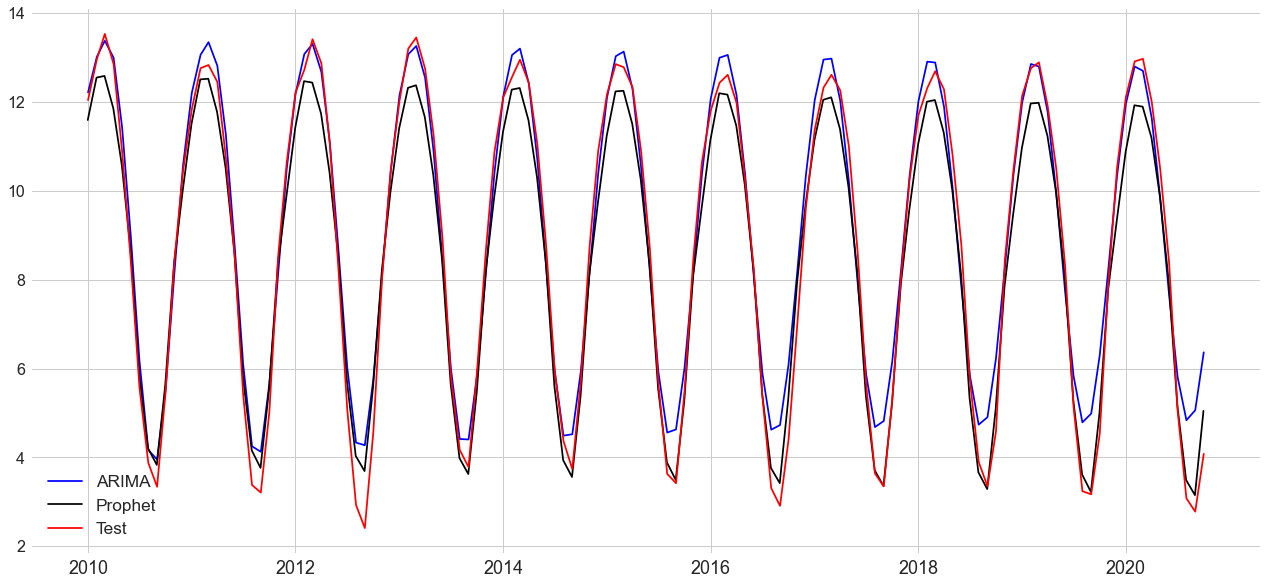

In [43]:
plt.figure(figsize=(22, 10))
plt.plot(arima_pred.index, arima_pred, label='ARIMA', color='b')
#plt.plot(sarima_pred.index, sarima_pred, label='SARIMA', color='y')
plt.plot(forecast['ds'][371:], forecast['yhat'][371:], label='Prophet', color='k')
plt.plot(test.index, test, label='Test', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

The results show that both models are capable of following the pattern observed in the test data, but each seems to miss in different areas. It is worth noting that the fbprophet model was obtained without any manual tunning, whereas the ARIMA models was created after performing a grid search for its parameters that took quite some time. It seems that fbprophet still does not have a method to calculate the AIC and BIC values. In an attempt to calculate the MSE to compare with the one obtained for the ARIMA(9,1,4) with a value of 0.119 the fbprophet cross_validation and performance_metrics methods were used. The value returned was 7.74, much higher than the one obtained from the ARIMA model.

### References
1. Fetterer, F., K. Knowles, W. N. Meier, M. Savoie, and A. K. Windnagel. 2017, updated daily. Sea Ice Index, Version 3. [Indicate subset used]. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center. doi: https://doi.org/10.7265/N5K072F8. [11/13/2020]
2. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
3. https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
4. https://www.youtube.com/watch?v=D9y6dcy0xK8
5. https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
6. https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
7. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
8. https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
9. https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.plot_predict.html?highlight=plot_predict#statsmodels.tsa.arima_model.ARIMAResults.plot_predict
10. https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
11. https://facebook.github.io/prophet/docs/quick_start.html
12. https://towardsdatascience.com/a-quick-run-through-of-holt-winters-sarima-and-fb-prophet-c6370c6f32f1